In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [115]:
import numpy as np
import matplotlib.pyplot as pl
from scipy import interpolate
import h5py
import qnm
from numpy import vectorize
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import least_squares
pl.rc('figure', figsize=(6.1, 4.5))
pl.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.serif': ['Georgia'],
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 2.5,
                     'font.size': 14,
                     'xtick.labelsize': 'medium',
                     'ytick.labelsize': 'medium',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'axes.grid': False,
                     'grid.alpha': 0.73,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 12,
                     'legend.framealpha': 0.7,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.2,
                     'legend.loc': 'best',
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

In [116]:
# define sampling rate and duration (make these powers of two) 
fsamp = 8192
duration = 0.08
t0 = 0

delta_t = 1/fsamp
tlen = int(round(duration / delta_t))
epoch = t0 - 0.5*tlen*delta_t

time = np.arange(tlen)*delta_t + epoch

In [117]:
chi=0.692085186818
M_est=65
t_unit=M_est*2950./2/299792458

In [118]:
mag_from_nr=10*np.array([  0.13657646 +0.95055905j,   3.14657959 -2.71266413j,
       -10.84170677 +3.607406j  ,  22.67958241 -8.01885436j,
       -30.44795174+19.91714543j,  22.09429848-26.19835642j,
        -7.43071591+15.89029183j,   1.0005728  -3.63046079j])

In [119]:
def h22new(a,mass,n,t):
    t_unit1=mass*2950./2/299792458
    htot=[]
#     htot+=[np.exp(0*t)]
    for i in range(n+1):
        grav = qnm.modes_cache(s=-2,l=2,m=2,n=i)
        omega, A1, C = grav(a=a)
        htot+=[np.exp(-1j*(omega)/t_unit1*abs(t))]
    return np.array(htot).T

In [120]:
def construct_qnm(n,chi,M_est,time):
    t_unit1=M_est*2950./2/299792458
    datalist=h22new(chi,M_est,n,time)
    construct=np.sum(datalist*mag_from_nr[:(n+1)],axis=1)#*np.heaviside(time+0*t_unit1,1)
    construct_new=np.nan_to_num(construct)
    return np.real(construct_new)


In [121]:
def get_signal(n,chi,M_est,time):
    t_unit1=M_est*2950./2/299792458
    construct_new=construct_qnm(n,chi,M_est,time)
    fpsi422=np.fft.rfft(construct_new,norm='ortho')
    ffreq=np.fft.rfftfreq(len(construct_new),d=(time[1]-time[0])/t_unit1)*2*np.pi
    return construct_new,ffreq,fpsi422

In [122]:
def get_signal_overtone(n,chi,M_est,time):
    t_unit1=M_est*2950./2/299792458
    grav = qnm.modes_cache(s=-2,l=2,m=2,n=n)
    omega, A1, C = grav(a=chi)
    construct=np.exp(-1j*(omega)/t_unit1*abs(time))*mag_from_nr[n]
    construct_new=np.nan_to_num(construct)
    return np.real(construct_new)

In [123]:
def fac(ffreq,l,m,n,chi,mass):
    t_unit=mass
    ome=qnm.modes_cache(s=-2,l=l,m=m,n=n)(a=chi)[0]
#     return (ffreq-ome)/(ffreq-np.conj(ome))
    return (ffreq*t_unit-ome)/(ffreq*t_unit-np.conj(ome))*(ffreq*t_unit+np.conj(ome))/(ffreq*t_unit+ome)

In [124]:
chi_filter=chi
mass_filter=1.

In [125]:
signal,ffreq,fpsi422 = get_signal(1,chi,M_est,time)
first_overtone = get_signal_overtone(1,chi,M_est,time)

cond_data=np.fft.irfft(fac(-ffreq,2,2,0,chi_filter,mass_filter)*fpsi422,norm='ortho',n=len(signal))

(0.001, 100)

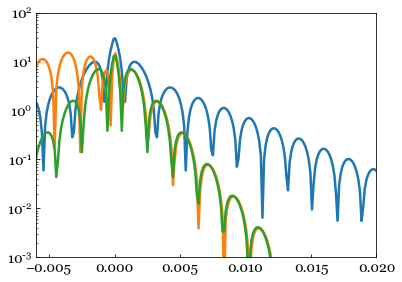

In [129]:
pl.semilogy(time,abs(signal))
pl.semilogy(time,abs(cond_data))
pl.semilogy(time,0.48*abs(first_overtone))
pl.xlim(-0.006, 0.02)
pl.ylim(1e-3,100)

In [130]:
def reduce_fact(chi):
    ome1=qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=chi)[0]
    ome0=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=chi)[0]
    fac11=(ome1-ome0)/(ome1-np.conjugate(ome0))
    fac22=(ome1+np.conjugate(ome0))/(ome1+(ome0))
    return fac11*fac22

In [131]:
reduce_fact(chi)

(0.48390318268201665+0.05413389358915566j)